In [126]:
import pandas as pd
import numpy as np
import yfinance as yf

import matplotlib.ticker as mtick

In [83]:
# https://fred.stlouisfed.org/series/FEDFUNDS
fed_rate = pd.read_csv("FEDFUNDS.csv").rename(columns=lambda xs: xs.lower())
fed_rate.date = pd.to_datetime(fed_rate.date)
fed_rate = fed_rate.set_index("date")

rfr = (
    fed_rate.iloc[lambda df: df.index.searchsorted(rets.index) - 1]
    .set_index(rets.index).fedfunds
    .div(100).div(250).rename(None)
)

In [63]:
symbols = {}
for s in ["SPY", "ULPIX"]:
    df = yf.Ticker(s).history(period='max', auto_adjust=True)
    df.index = df.index.tz_convert(None).floor("D")
    df["ret"] = df["Close"].transform(lambda xs: xs / xs.shift() - 1)
    symbols[s.lower()] = df

In [64]:
rets = pd.DataFrame({k: v["ret"] for k, v in symbols.items()})

In [117]:
rets["2spy"] = rets["spy"] * 2
rets["3spy"] = rets["spy"] * 3

In [66]:
rets = rets.dropna().copy()

In [108]:
rets

,spy,ulpix,2spy
Date,,,
1997-12-01,0.025817,0.051895,0.051634
1997-12-02,-0.006053,-0.008539,-0.012105
1997-12-03,0.002885,0.004786,0.005770
1997-12-04,-0.000959,-0.001906,-0.001918
1997-12-05,0.012796,0.020038,0.025592
...,...,...,...
2024-02-27,0.001858,0.003333,0.003715
2024-02-28,-0.001322,-0.003322,-0.002643
2024-02-29,0.003595,0.009908,0.007190


<AxesSubplot: xlabel='Date'>

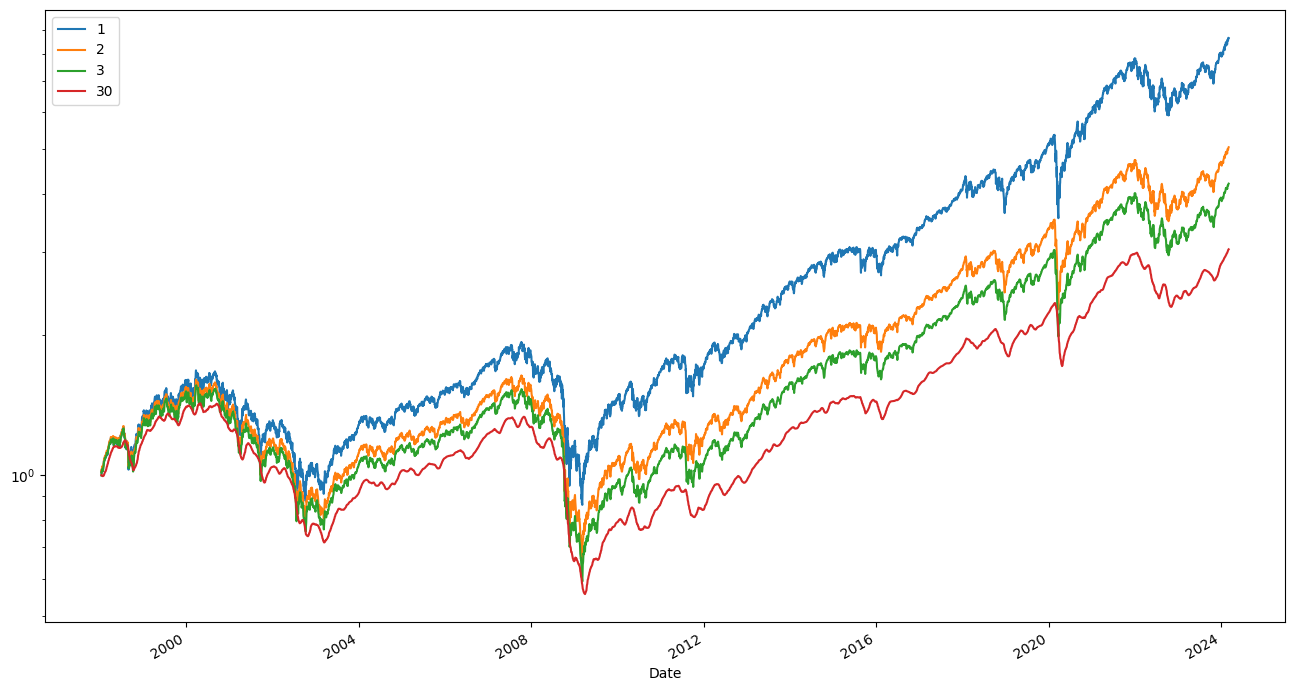

In [125]:
rebalancing_df = pd.concat([
    rets["3spy"].add(1).apply(np.log).rolling(n).mean().apply(np.exp).add(2).div(3)
    .rename(n)
    for n in [1, 2, 3, 30]
], axis=1).dropna()
rebalancing_df.cumprod().plot(figsize=(16, 9), logy=True)

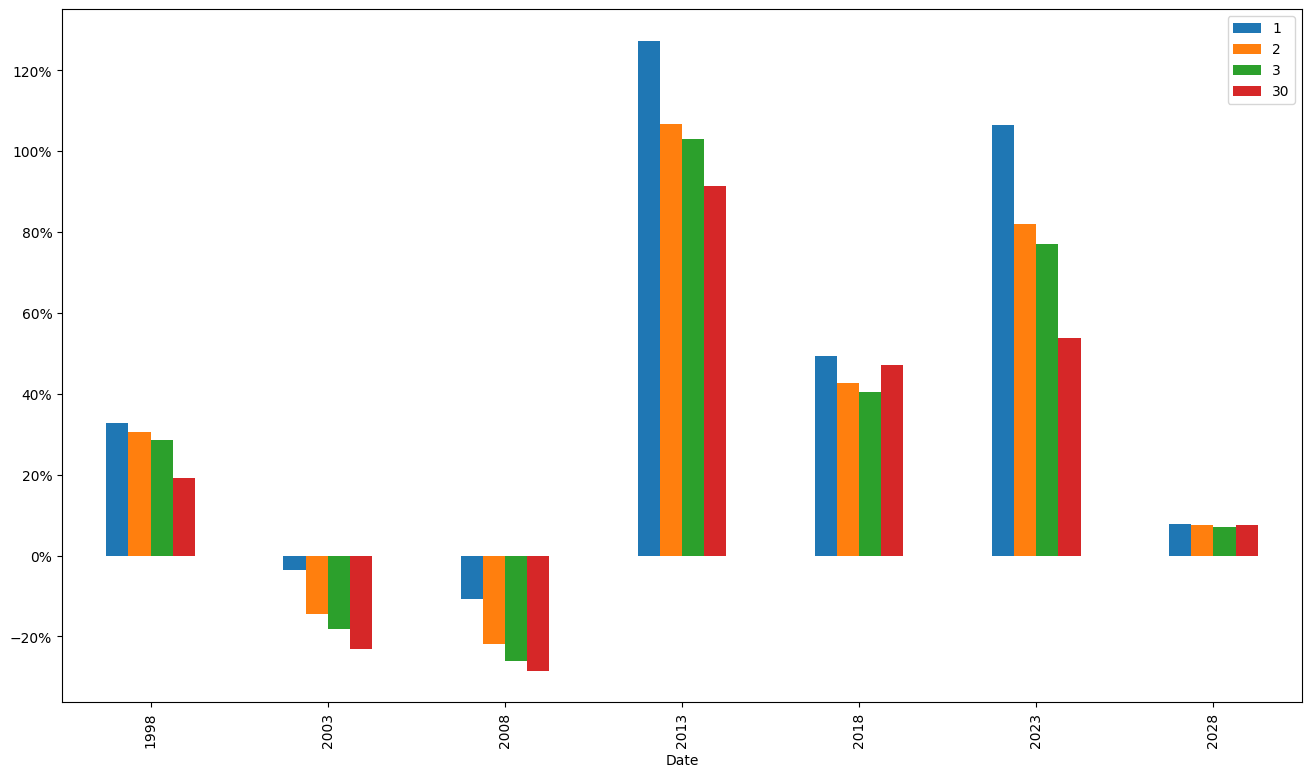

In [128]:
ax = (
    rebalancing_df.groupby(pd.Grouper(freq="5Y")).prod().sub(1)
    .rename(lambda xs: xs.year).plot.bar(figsize=(16, 9))
)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))